# Lab 6 - Cost Functions and Parameter Space: Solving models the hard way
---------------------------------------------------------------------------------

Author: Kevin Paganini   
Date: 10/19/2022
Description: In this lab we first implemented a gaussian and multiple linear regression model.   
Specifically, we made the predict, mean_squared_error, constructor and cost functions. After this   
was implemented, we started our notebook and did a grid search for a guassian model that produced some decent results. To improve on these results we did a finer grid search over different standard deviations. After this we performed a grid search on a model with 4 parameters instead of 2 and found some results. Throughout the experimentation process many plots were produced to showcase the results.


# Questions


1. By looking at the provided cost_functions.py, use 1-2 sentences to describe in detail the purpose of each of the methods. To guide this description, discuss the method input, method output, and what function each method serves for the cost function.
    - init takes in the training samples and the targets of each. It does not output anything it is there to initialize the model. 
    - Predict: Takes in a set of features which are data samples and a set of parameters which are the model parameters in the gaussian model this is the mean and std and in the linear model this is the weights for each feature. The function outputs the predictions for the provided data samples (Shape of features: (num samples, num features)). The predictions shape is (num samples, 1)
    - _mse: This function calculates the mean squared error between the actual target value and the predicted value. It simply takes two lists of the same shape and returns the mean squared error.
    This is a "private" function since it has an underscore in the front. It is used in the cost function. 
    - cost: is the predict and the _mse method put together. It takes in a set of parameters you want to use for the model and then makes predictions on the training samples provided in the init method. Once predictions are done it calculates the mean squared error between the predictions and the targets that were also provided during initialization.


2. For the heatmaps that you generated for this lab, what do they describe? What do the “valleys” and “peaks” of this heat map represent?


    - The valleys represent low points in the error, while peaks represent maximums in our error. Since we are trying to minimize the error we want to look for peaks, this is why we select parameters where the heatplot is darker in our case. 


3. For experiment 2, you increased the number of samples within the specified range. 
    1. Describe how the heatmap representation changed due to this increase in sampling. 
        - When we sampled between 1 and 1.75 we were able to better pick parameters that fit the data. From the first experiment we saw that the values between 1 and 1.75 had a lot of potential. It gave us more precision in parameter space and allowed us to choose even better parameters. Sampling between 5 and 6 was worse than sampling between 1 and 1.75.
        
    2. What benefit did this higher sampling rate have for finding the set of parameters with the minimum error? 
        - From experiment 1 we knew parameters in the range of 1 were a good solution to the problem the finer gridsearch gave us a m,ore accurate estimate of the true best parameters.
    
    3. Was this sampling rate high enough? Defend your answer!
        - The sampling rate can never be high enough in my opinion. The sampling rate you choose depends on how accurate you want your estimate of the model parameters to be. If you want a very accurate model than you should have a very fine grid search. However if a model that is 75% accurate is all you need, a fine grid search is not needed. The Sampling rate depends on how accurate you need your model parameters to be. The finer the gridsearch the finer the model parameters.

4. The Gaussian distribution model is limited to two dimensions while the multivariate linear model implemented for this lab is 4 dimensional. 
    1. Describe a limitation of the grid search method as you add additional dimensions. Hint: Think about the time complexity required for the grid search as you add additional dimensions. 
        - Time complexity of a one dimensional problem is O(n), where n is the number of points in gridspace that you want to search. When it is two parameters this immediately becomes $O(n^2)$ and so on. The more features you have the higher the power. Which makes this impossible when dimensionality is high.

    2. With time complexity in mind, can you derive a rule (mathematical expression) to estimate how many grid points are needed to evaluate all combination of parameters based on the number of dimensions.     
    x = num features    
    y = number of samples wanted per dimension   
    $$
    gridPoints = y^x

    $$
    

    3. With this rule, compare 2-dimensional models with 4-dimensional models. 10-dimensional? 100-dimensional?

    - Lets say we want 10 samples per dimension. Obviously you could choose custom samples for each dimension but that would make the math a lot less pretty.

    $$
    grid_{2} = 10^2 = 100\\
    grid_{4} = 10^4 = 10000\\
    grid_{10} = 10^{10} = 10000000000\\
    grid_{100} = 10^{100} = 10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    $$

In experiment 3 you plotted the line of identity in the figure that compared the given response variable to the model prediction. 
    1. What does this line represent and how is it useful? 
        - If the model were perfect every point would be on this line. The distance from the line represents the error between prediction and actual.
    2. What does it mean for a value to lie above the line? Below the line? 
        - In both cases above or below it isn't a good thing. If it is above the line (depending on what you choose to be on the x_1 and x_2 axis). The prediction is greater than the actual value. In the other the prediction is lower than the actual value. (Assuming predictions is on the x_2 axis and actual targets are on the x_1)
    3. How would predictions that perfectly replicate the given data appear in this plot?
        - As stated previously they would directly be on the line. 

What are the weaknesses of grid search? Why wouldn't we want to use it?

If the dimensions get higher than five or so, it basically becomes impossible to run a gridsearch that is fine enough to search the parameter space coarsely enough. The run time just takes too long. If you have ten parameters and want 100 samples in each dimension, that is $100^{10}$ operations, which isn't computable for a couple years, until we get quantum computers *evil laugh*. Then I will grid search everything and never use gradient descent again.

### Setup and imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




## Helper function to make figures look pretty
def make_pretty(ax, title='', x_label='', y_label='', img=False):
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    if img:
        ax.axis('off')
        
    return ax

### Experiment 1 - Part 1 and 2:
1. Load the gaussdist.csv into your notebook.
2. Identify the columns associated with the response variable and the feature variable. Hint Look at the expected output for a gaussian – it is not monotonic. The relationship between independent and dependent values is 1-to-1.

In [3]:
gauss_dist = pd.read_csv("gaussdist.csv", header=None)
gauss_dist.columns = ['feature', 'response']
gauss_dist.head()

,feature,response
0,6.99,0.156842
1,8.90,0.007897
2,9.58,0.001551
3,5.46,0.318990
4,1.38,0.001396


The first column is the feature.  
The second column is the response.

### Experiment 1 - Part 3:

3. The features and response variables should be stored in separate numpy arrays.

In [4]:
X = np.array(gauss_dist['feature'].values)
y = np.array(gauss_dist['response'].values)


### Experiment 1 - Part 4:
4. Instantiate your cost function class for GaussianCostFunction using the provided data.

In [5]:
from cost_functions import GaussianCostFunction

gauss_model = GaussianCostFunction(X, y)

### Experiment 1 - Part 5:
5. Plot the feature (x-axis) versus the response (y-axis) of the gaussdist.csv dataset. Make sure to label your plot.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:title={'center':'Gaussian Distribution'}, xlabel='feature', ylabel='response'>

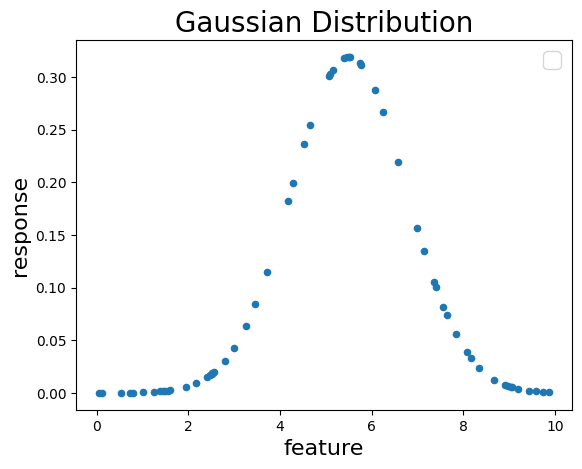

In [6]:
ax = gauss_dist.plot(kind='scatter', x='feature', y='response')
make_pretty(ax, 'Gaussian Distribution', 'feature', 'response')

### Experiment 1 - Part 6 and 7:
6. Use the parameter set (μ=1 and σ=0.75) and the _predict method to generate your model predictions and plot them on the same plot as the original data.

7. Use the cost method to solve for the error and add this error to the plot’s title.

<AxesSubplot:title={'center':'Gaussian Distribution (Error: [0.0624221])'}, xlabel='feature', ylabel='response'>

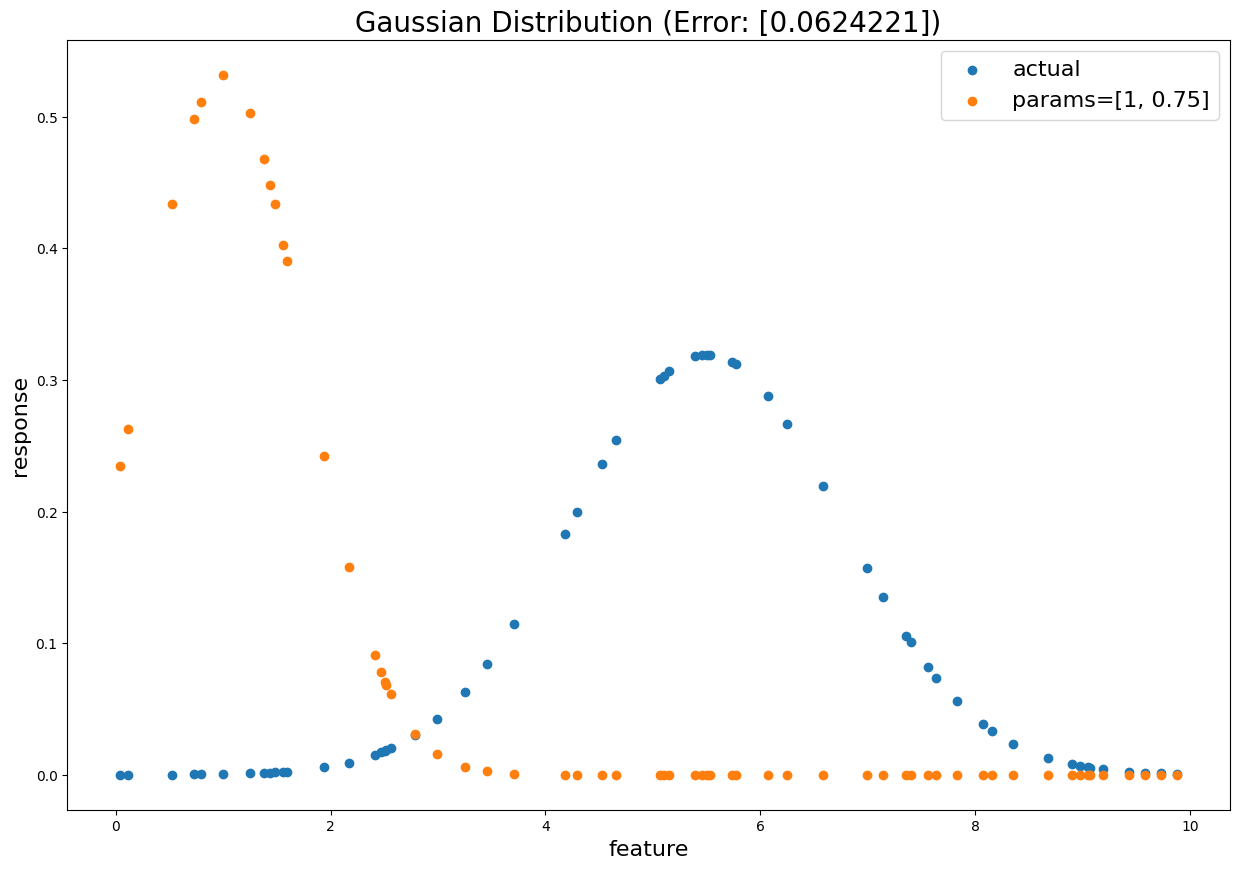

In [7]:
pred = gauss_model.predict(X, [1, 0.75])

error = gauss_model.cost([1, 0.75])


fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(x=gauss_dist['feature'], y=gauss_dist['response'], label='actual')
ax.scatter(X, pred, label='params=[1, 0.75]')
make_pretty(ax, f'Gaussian Distribution (Error: {error})', 'feature', 'response')

## Experiment 1 - Second part of it:

Grid Search - Coarse Blindly guessing at good parameters is no way to go through life. Now that you have a function that accepts a set of parameters and returns the error, let’s explore the error space by evaluating an evenly spaced set of model parameters – a grid search.



### Experiment 1 - part 1 and 2:


In [8]:
mean = np.linspace(0, 10, 101) # make them nicely space
std_dev = np.linspace(0.5, 2, 50)


### Experment 1 - part 3:



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:title={'center':'Heatmap of gridsearch for best params'}, xlabel='standard deviation', ylabel='mean'>

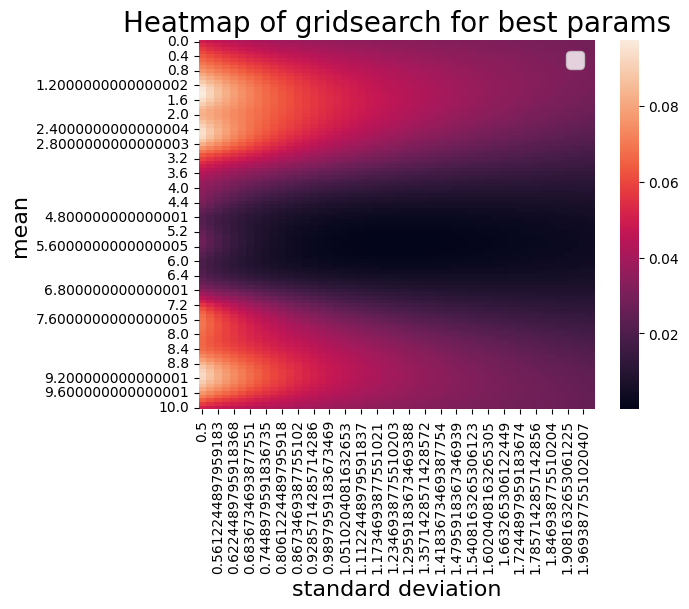

In [9]:
errors = []
xx, yy = np.meshgrid(mean, std_dev)
params = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))

for param in params:
    errors.append(gauss_model.cost(param)) 
    
errors = np.array(errors).reshape(5050, 1)
plot_data = np.hstack((params, errors))
df = pd.DataFrame(plot_data, columns=['mean', 'std', 'error'])

df = df.pivot('mean', 'std', 'error')



ax = sns.heatmap(df)
make_pretty(ax, 'Heatmap of gridsearch for best params', 'standard deviation', 'mean')

### Experiment 1 - part 4:

I am choosing the parameters 5.6 for the mean and 1.9 for the std


### Experiment 1 - part 5:


<AxesSubplot:title={'center':'Gaussian Distribution (Error: [0.00274506])'}, xlabel='feature', ylabel='response'>

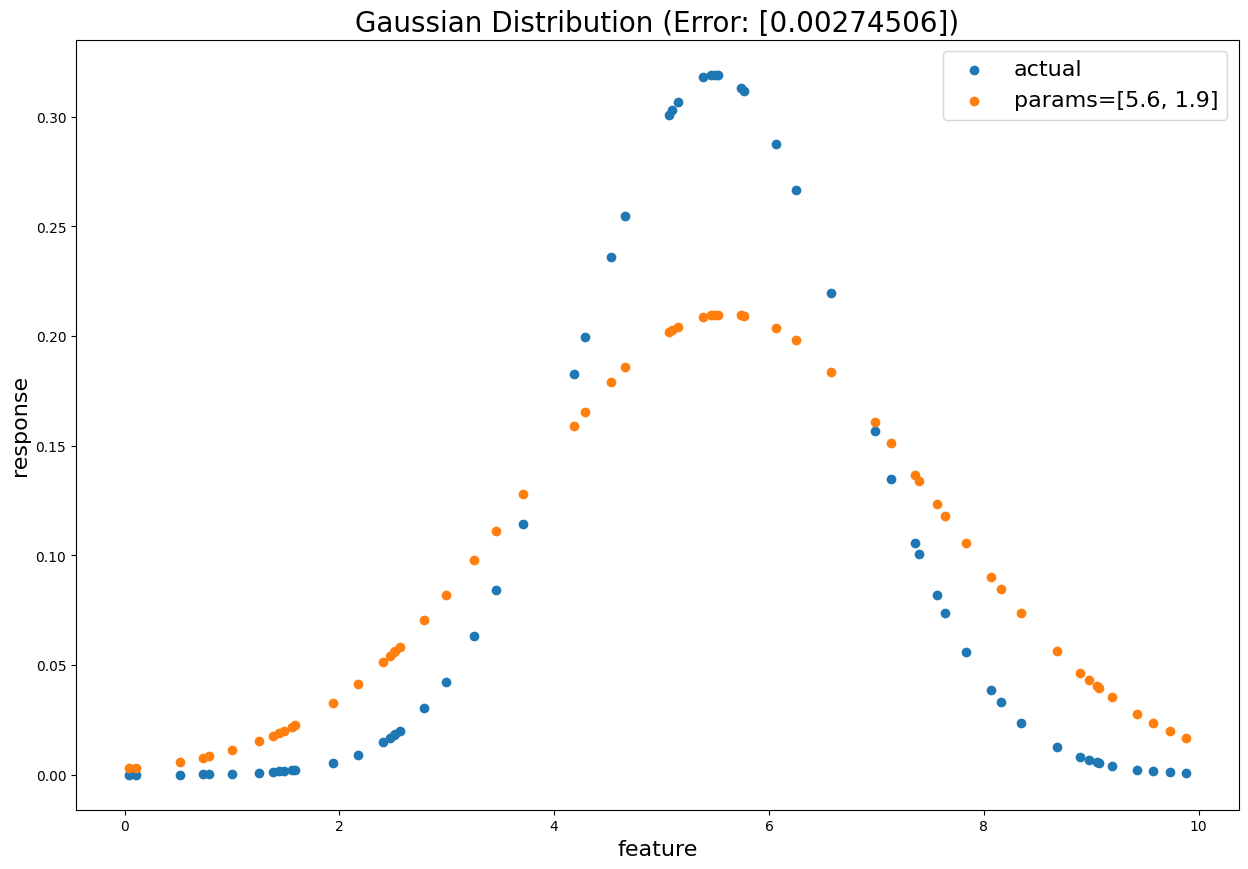

In [10]:
pred = gauss_model.predict(X, [5.6, 1.9])

error = gauss_model.cost([5.6, 1.9])


fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(x=gauss_dist['feature'], y=gauss_dist['response'], label='actual')
ax.scatter(X, pred, label='params=[5.6, 1.9]')
make_pretty(ax, f'Gaussian Distribution (Error: {error})', 'feature', 'response')

### Experiment 2: Refined Grid Search – Gaussian Distribution

### Experiment 2 - part 1 and 2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:title={'center':'Heatmap of gridsearch for best params (5-6 std)'}, xlabel='standard deviation', ylabel='mean'>

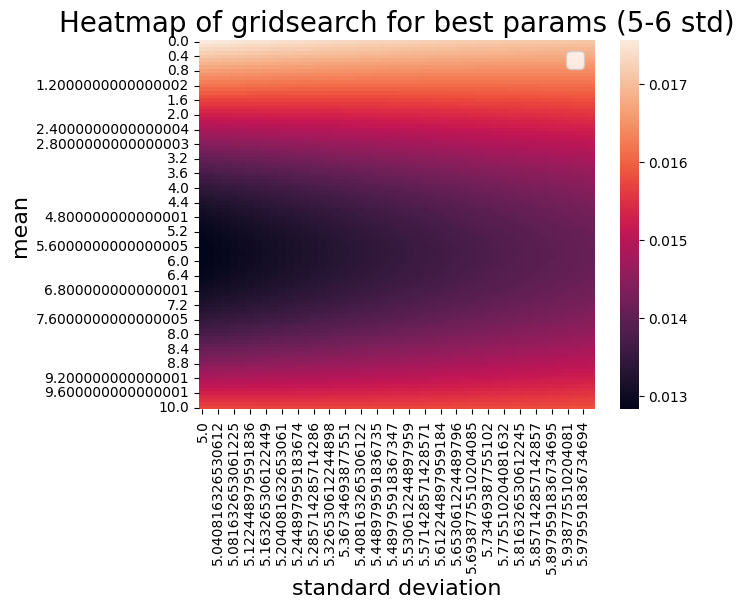

In [11]:
std1 = np.linspace(5, 6, 50)
std2 = np.linspace(1, 1.75, 50)



xx, yy = np.meshgrid(mean, std1)
xxx, yyy = np.meshgrid(mean, std2)

params_1 = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
params_2 = np.hstack((xxx.reshape(-1, 1), yyy.reshape(-1, 1)))

errors_1 = []

for param in params_1:
    errors_1.append(gauss_model.cost(param)) 

errors_2 = []
for param in params_2:
    errors_2.append(gauss_model.cost(param))  

    
errors_1 = np.array(errors_1).reshape(5050, 1)
erros_2 = np.array(errors_2).reshape(5050, 1)
plot_data_1 = np.hstack((params_1, errors_1))
plot_data_2 = np.hstack((params_2, errors_2))

df_1 = pd.DataFrame(plot_data_1, columns=['mean', 'std', 'error'])
df_2 = pd.DataFrame(plot_data_2, columns=['mean', 'std', 'error'])
df_1 = df_1.pivot('mean', 'std', 'error')
df_2 = df_2.pivot('mean', 'std', 'error')


ax = sns.heatmap(df_1)
make_pretty(ax, 'Heatmap of gridsearch for best params (5-6 std)', 'standard deviation', 'mean')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:title={'center':'Heatmap of gridsearch for best params (1-1.75 std)'}, xlabel='standard deviation', ylabel='mean'>

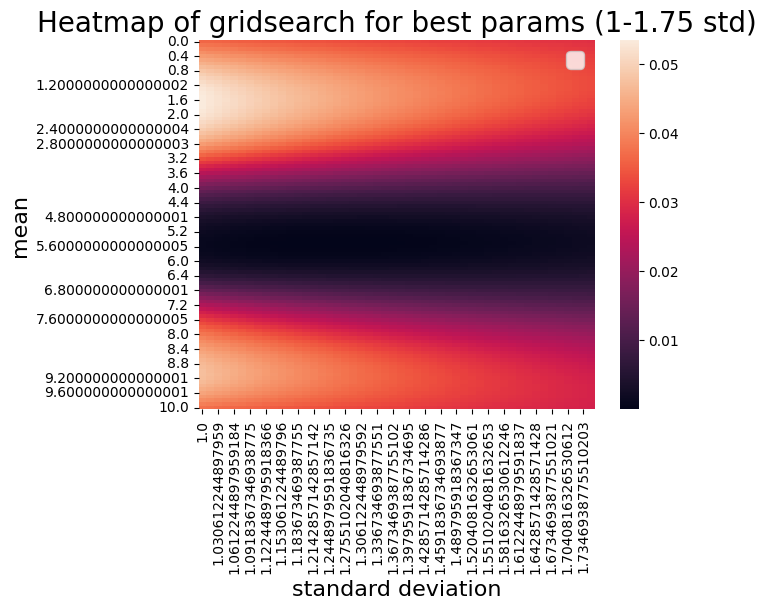

In [12]:
ax = sns.heatmap(df_2)
make_pretty(ax, 'Heatmap of gridsearch for best params (1-1.75 std)', 'standard deviation', 'mean')

When the standard deviation is between 5 and 6 the error is higher than between 1 and 1.75





### Experiment 2 - part 3
picking params = [5.6, 1.28]

<AxesSubplot:title={'center':'Gaussian Distribution (Error: [7.03086517e-05])'}, xlabel='feature', ylabel='response'>

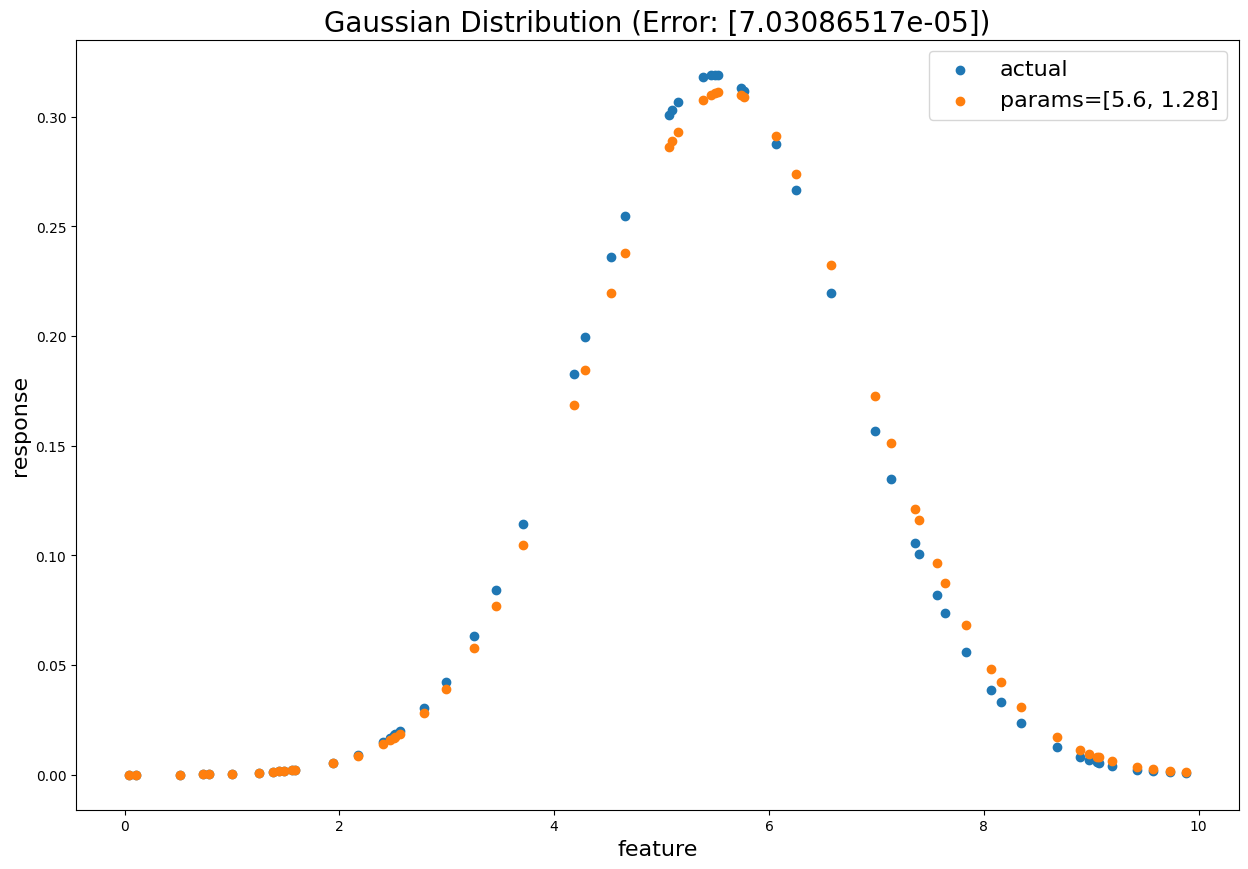

In [13]:
pred = gauss_model.predict(X, [5.6, 1.28])

error = gauss_model.cost([5.6, 1.28])


fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(x=gauss_dist['feature'], y=gauss_dist['response'], label='actual')
ax.scatter(X, pred, label='params=[5.6, 1.28]')
make_pretty(ax, f'Gaussian Distribution (Error: {error})', 'feature', 'response')


### Experiment 2 - part 4:

In [14]:
min_index = np.argmin(errors)
print(min_index)

print(params[min_index])
print(errors[min_index])

2580
[5.5        1.26530612]
[2.96013245e-06]


## Experiment 3  Blind Grid Search

### Experiment 3 - Bullet 1


In [15]:
from cost_functions import LinearCostFunction


df = pd.read_csv('advertising.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

X_train = df[['Offset', 'TV', 'radio', 'newspaper']].values
y_train = df[['sales']].values

print(X.shape)
print(y.shape)
lcf = LinearCostFunction(X_train, y_train)


(60,)
(60,)


### Experiment 3 - Bullet 2:

In [16]:
predictions = lcf.predict(X_train,[0.1, 0.1, 0.1, 0.1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)
(200, 4)


<AxesSubplot:title={'center':'Prediction vs Response'}, xlabel='True y', ylabel='predicted y'>

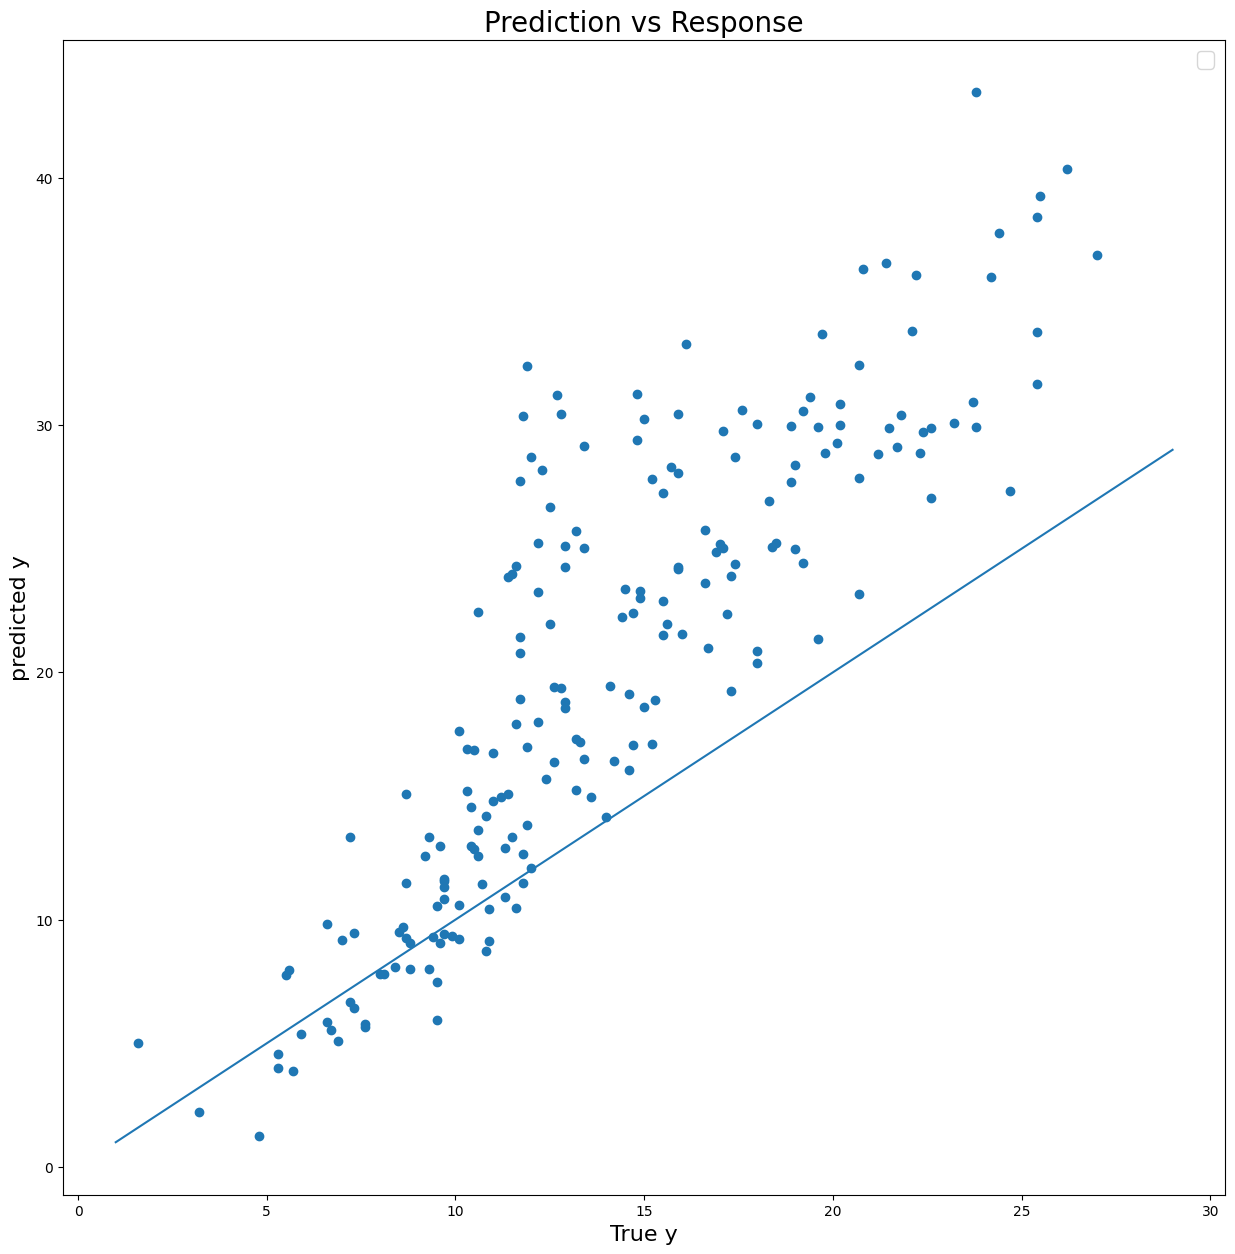

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))
line_x = np.arange(1, 30)
print(predictions.shape)
print(X_train.shape)

ax.plot(line_x, line_x)
ax.scatter(y_train, predictions)

make_pretty(ax, 'Prediction vs Response', 'True y', 'predicted y')

It seems like the model is generally overestimating the true value since most points are above the identity line

### Experiment 3 - Bullet 3 and 4:


In [27]:
lcf_2 = LinearCostFunction(X_train, y_train)

# I think this gridsearch should be good
# I was looking at feature correlations and made a guess
# Now im looking around my guessed weights
feat_1 = np.linspace(-0.01, 0.01, 50)
feat_2 = np.linspace(0, 0.05, 50)
feat_3 = np.linspace(0.1, 0.2, 50)
feat_4 = np.linspace(-0.05, 0.05, 50)
mse = []
best_cost = 100000
best_params = None
# quad baby

ww, xx, yy, zz = np.meshgrid(*[feat_1, feat_2, feat_3, feat_4])
params = np.hstack((ww.reshape(-1,1), xx.reshape(-1,1), yy.reshape(-1,1), zz.reshape(-1,1)))

for w in feat_1:
    for x in feat_2:
        for y in feat_3:
            for z in feat_4:
                cost = lcf_2.cost([w, x, y, z])
                mse.append(cost)
                if cost < best_cost:
                    best_params = [w, x, y, z]
                


[array([[-0.01      ,  0.        , -0.00959184, ...,  0.05      ,
          0.01      ,  0.05      ],
        [-0.01      ,  0.        , -0.00959184, ...,  0.05      ,
          0.01      ,  0.05      ],
        [-0.01      ,  0.        , -0.00959184, ...,  0.05      ,
          0.01      ,  0.05      ],
        ...,
        [-0.01      ,  0.        , -0.00959184, ...,  0.05      ,
          0.01      ,  0.05      ],
        [-0.01      ,  0.        , -0.00959184, ...,  0.05      ,
          0.01      ,  0.05      ],
        [-0.01      ,  0.        , -0.00959184, ...,  0.05      ,
          0.01      ,  0.05      ]]),
 array([[ 0.1       ,  0.1       ,  0.1       , ...,  0.1       ,
          0.1       ,  0.1       ],
        [-0.05      , -0.05      , -0.05      , ..., -0.05      ,
         -0.05      , -0.05      ],
        [ 0.10204082,  0.10204082,  0.10204082, ...,  0.10204082,
          0.10204082,  0.10204082],
        ...,
        [ 0.05      ,  0.05      ,  0.05      , ...,  

### Experiment 3 - Bullet 5:

In [19]:
least_error = np.argmin(mse)
best_params

[0.01, 0.05, 0.2, 0.05]

In [20]:

mse[least_error]

array([4.50100462])

### Epxeriment 3 - Bullet 6:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:title={'center':'Prediction vs. Result'}, xlabel='actual', ylabel='prediction'>

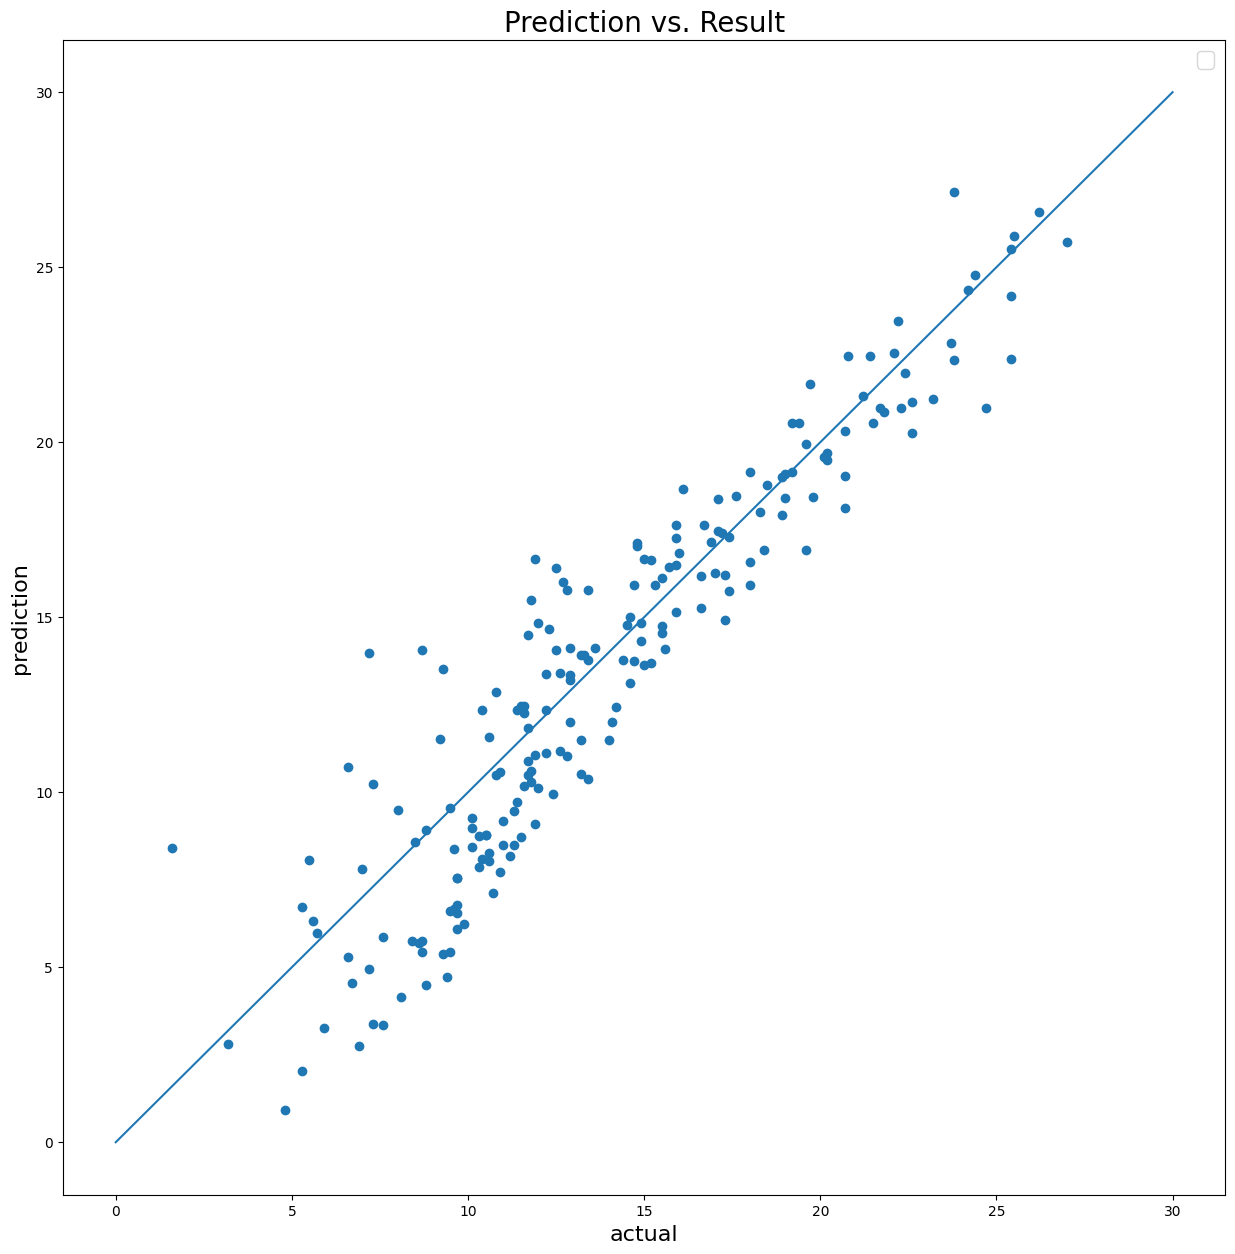

In [21]:
fig, ax = plt.subplots(figsize=(15, 15))

x_line = np.linspace(0, 30, 50)

predictions = lcf_2.predict(X_train, best_params)

ax.plot(x_line, x_line)
ax.scatter(y_train, predictions)
make_pretty(ax, 'Prediction vs. Result', 'actual', 'prediction')

### Appendix

Were gonna find the actual parameers that are good

Best Coefficients: [[ 0.          0.04576465  0.18853002 -0.00103749]]
Best Intercept: [2.93888937]
Error: 2.784126314510936


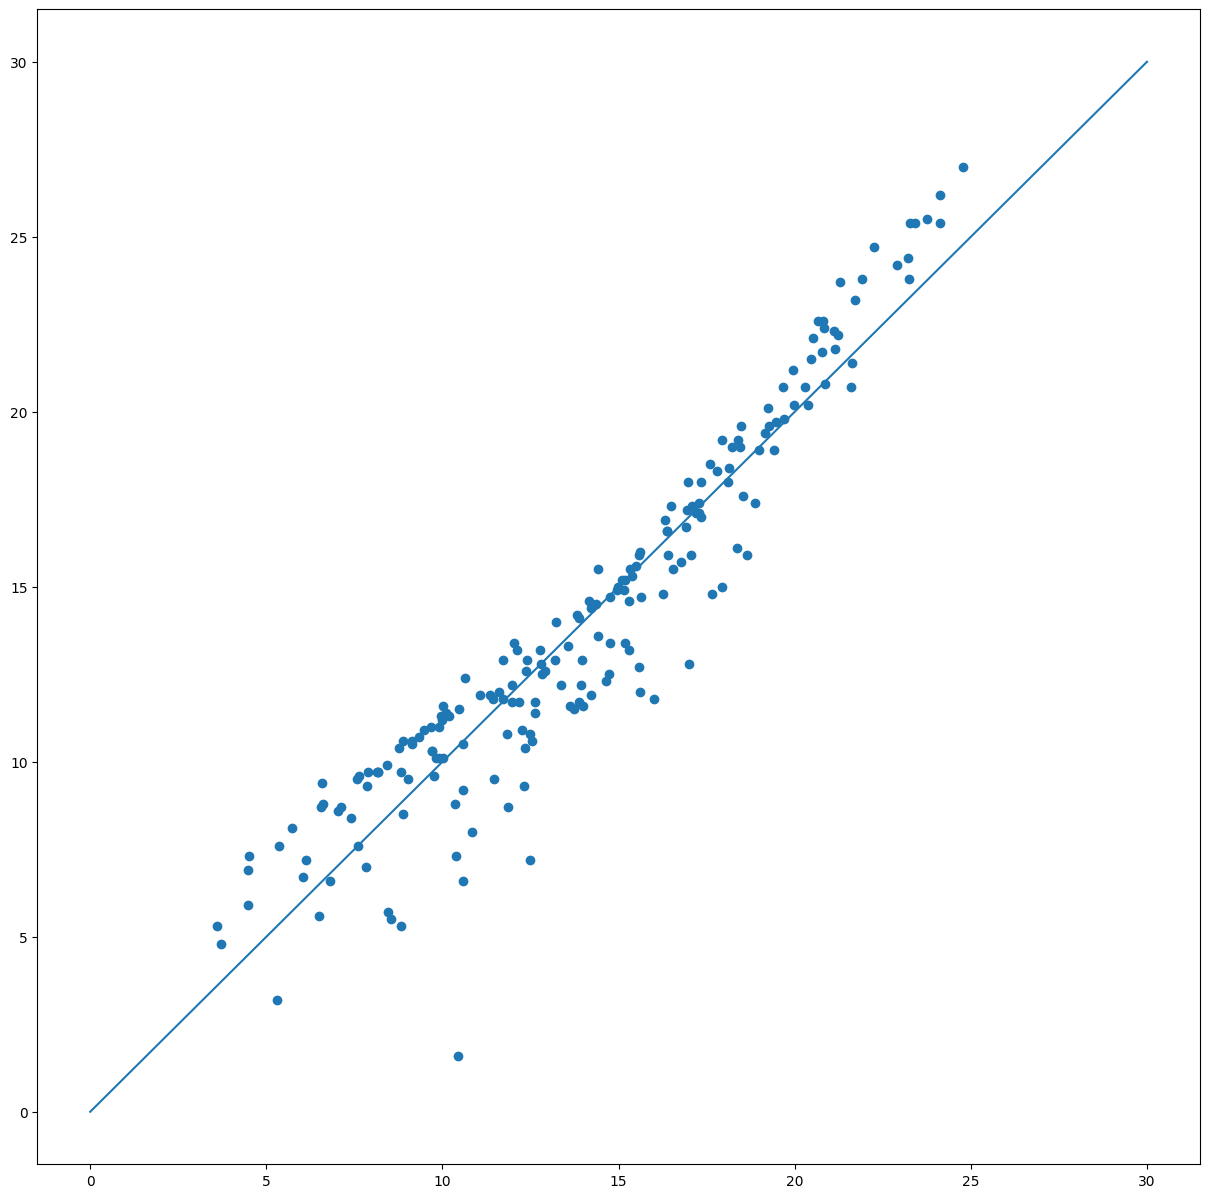

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)



predictions = lin_reg.predict(X_train)

fig, ax = plt.subplots(figsize=(15, 15))

ax.plot(x_line, x_line)
ax.scatter(predictions, y_train)

print(f'Best Coefficients: {lin_reg.coef_}')
print(f'Best Intercept: {lin_reg.intercept_}')
print(f'Error: {mean_squared_error(predictions, y_train)}')